### introduction

Here we will go through application of the Pérez-Priego partitioning algorithm to eddy covariance data. The script is designed to run on [FLUXNET2015](https://fluxnet.fluxdata.org/data/fluxnet2015-dataset/) .csv files directly, which ensures consistent variable names, processing and units. The tutorial will use data from the [Hyytiälä forest](http://sites.fluxdata.org/FI-Hyy/) in Finland, but can be applied to any FLUXNET2015 dataset.

Some experience in R will make things easy, but I will try to explain the process step by step so as to be accessible to all backgrounds.

This example has been adapted from the original example:

https://github.com/oscarperezpriego/ETpartitioning/blob/master/inst/main_ETpartitioning.r

### first things first

The firs step is to import all needed packages:

In [ ]:
library(ETpartitioning) # The package containing the partitioning code
library(FME)            # Package for parameter optimization
library(bigleaf)

Loading required package: deSolve
Loading required package: rootSolve
Loading required package: coda


### loading the dataset

Here we open the .csv file. Only the years from 2008 to 2013 are used from the full timeseries. This will load all variables.

In [ ]:
ds = read.csv("FLX_FI-Hyy_FLUXNET2015_FULLSET_HH_2008-2010_1-3.csv")

### estimating long-term effective $\chi_{o}$ and $WUE_{o}$ parameters

The first step is to calculate $\chi_{o}$ via:

$$ln\left ( \frac{\chi_{o}}{1-\chi_{o}} \right ) = 0.0545 \left ( \overline{Temp}-25 \right ) - 0.58 \cdot ln(\overline{D}) - 0.0815 \cdot Z + C$$

where $\overline{Temp}$ is the mean seasonal temperature and $\overline{D}$ in the mean seasonal VPD. This is accomplished using the `calculate_chi_o` function below. Here `Z` is the site altitude in kilometers and `C` is an empirical coefficient for  C3 species (Wang et al., 2017). The function takes the dataset `ds` as well as designations for the GPP (`ColPhotos`), VPD (`ColVPD`), and air temperature (`ColTair`) columns.

In [ ]:
Chi_o <- calculate_chi_o(data= ds
                         ,ColPhotos = "GPP_NT_VUT_USTAR50"
                         ,ColVPD = "VPD_F"
                         ,ColTair = "TA_F"
                         ,C = 1.189 ##<< Empirical coeficient for C3 species (see Wang et al., 2017; Plant Nature).
                         ,Z=0.181) ##<< altitude (km)

Second we calculate $WUE_{o}$ via:

$$WUE_{o} = C_{a} \cdot P_{a} \frac{  \left ( 1- \chi_{o} \right ) }{1.6 \cdot \overline{D}}$$

where $C_{a} and P_{a}$ are set to 390 ppm and 96 kPa, respectively. This is accomplished using the `calculate_WUE_o` function below with the same inputs as `calculate_chi_o`.

In [ ]:
WUE_o <- calculate_WUE_o(data= ds
                         ,ColPhotos = "GPP_NT_VUT_USTAR50"
                         ,ColVPD = "VPD_F"
                         ,ColTair = "TA_F"
                         ,C = 1.189 ##<< Empirical coeficient for C3 species (see Wang et al., 2017; Plant Nature).
                         ,Z=0.181) ##<< altitude (km)

### prepare for the partitioning

The partitioning step optimizes parameters for each day using a 5 day moving window. Here we convert the timestamp string in the original file into both the individual date and time components, giving each day an identifyer to use within the loop (`ds$loop`).

In [ ]:
ds$year <- (substr(ds$TIMESTAMP_END, 1, 4))
ds$Month <- as.numeric(substr(ds$TIMESTAMP_END, 5, 6))
ds$DD <- as.numeric(substr(ds$TIMESTAMP_END, 7, 8))
ds$Hour <- (substr(ds$TIMESTAMP_END, 9, 10))
ds$Min <-(substr(ds$TIMESTAMP_END, 11, 12))
ds$rDate <- strptime(paste0(ds$year,"/",ds$Month,"/",ds$DD," ", ds$Hour,":",ds$Min) , format="%Y/%m/%d %H:%M", tz='GMT')
ds$date <- strptime(paste0(paste0(ds$year,"/",ds$Month,"/",ds$DD)) , format="%Y/%m/%d", tz='GMT')
ds$loop <- as.numeric(as.Date(ds$date))-min(as.numeric(as.Date(ds$date)), na.rm=T)+1

### running a subset

The 4 model parameters (a1, Do, Topt and beta, see Perez-Priego et al., 2018) are estimated using a multi-constraint Markov Chain Monte Carlo (MCMC) over a given time period (e.g. 5 days). In the present form, the number of iterations was set to 20000, and the first half of the chains was discarded. We updated the proposed distribution every 500 iterations. Please note that this setup is computationally expensive, i.e. on my laptop with a single processor, one day takes about 2.5 to 3 minutes, or $\approx16$ hours for a year. As such, we will only run one day to demonstrate the process. If you have the time, feel free to run more days. Note that the MCMC can be customized as required in the `optimal_parameters` function to possibly reduce runtimes.

In [ ]:
days_to_run <- unique(ds$loop)[200:200]

unique(ds$date)[days_to_run]

[1] "2008-07-18 GMT"

### partitioning

For each day in `days_to_run` we make a temperary dataset (`tmp`) containing the 5 day window. The optimized model parameters are then estimated (`optimal_parameters`), which are then passed on the the transpiration model(`transpiration_mod`). The resulting `ET`, `transpiration`, and `evaporation` are then saved in the `estimates` dataset. Again, this is the step that takes the longest.

In [ ]:
estimation_out <-  list() ##<< Emptly list to save the estimates

start_time <- Sys.time() ##<< Save the start time to time the partitioning step

for (i in days_to_run){
  tmp <- subset(ds,loop %in% c(i-2,i-1, i,i+1, i+2)) ##<< Defining 5 days window in a loop

  tmp_day <- subset(tmp, NIGHT == 0)

  #-- optimize model parameters

  ans <-  optimal_parameters(par_lower= c(0,0, 10, 0)
                              ,par_upper = c(400,0.4, 30, 1)
                              ,data=tmp_day
                              ,ColPhotos="GPP_NT_VUT_USTAR50"
                              ,ColPhotos_unc="NEE_VUT_USTAR50_JOINTUNC"
                              ,ColH="H_F_MDS"
                              ,ColVPD="VPD_F"
                              ,ColTair="TA_F"
                              ,ColPair="PA_F"
                              ,ColQ="PPFD_IN"
                              ,ColCa="CO2_F_MDS"
                              ,ColUstar="USTAR"
                              ,ColWS="WS_F"
                              ,ColSW_in="SW_IN_F"
                              ,Chi_o = Chi_o
                              ,WUE_o= WUE_o)

  par <- as.numeric(ans)

  #-- estimating transpiration rates
    
  transpiration_mod <- transpiration_model(
      par=par
      ,data=tmp
      ,ColPhotos="GPP_NT_VUT_USTAR50"
      ,ColH="H_F_MDS"
      ,ColVPD="VPD_F"
      ,ColTair="TA_F"
      ,ColPair="PA_F"
      ,ColQ="PPFD_IN"
      ,ColCa="CO2_F_MDS"
      ,ColUstar="USTAR"
      ,ColWS="WS_F"
      ,ColSW_in="SW_IN_F"
      ,Chi_o = Chi_o
      ,WUE_o= WUE_o)

    
    
 
  #-- Converting units and estimating evaporation rates

  transpiration_mod <- transpiration_mod * (18.01528/1e6) *1800  # from mmol m-2 s-2 to mm per half hour
  ET <- LE.to.ET(tmp$LE_F_MDS,tmp$TA_F) * 1800 # from Wm-2 to mm per half hour
  evaporation_mod <- ET-transpiration_mod
    
  #-- output the estimates

  tmp$ET <- ET
  tmp$transpiration_mod <- transpiration_mod
  tmp$evaporation_mod <- evaporation_mod

  tmp <- tmp[tmp$loop == i,] ## selecting the central day
  estimation_out[[i]] <- tmp

}
end_time <- Sys.time()
end_time - start_time

estimates <- do.call(rbind, estimation_out)

number of accepted runs: 16008 out of 20000 (80.04%) 


Time difference of 2.88858 mins

Now we can make a simple plot. If you have also gone through the TEA_tutorial.ipynb, you can compare to two plots which both show ET, E, and T for July 18th 2008.

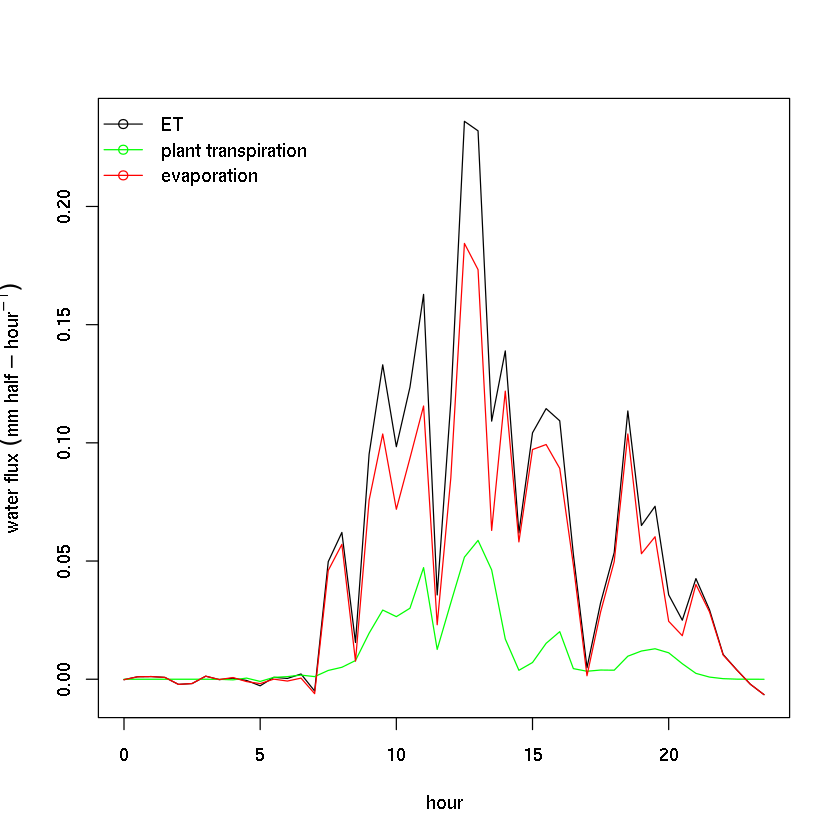

In [ ]:
hours = seq(0,23.5,0.5)
plot(hours, estimates$ET, type="l", ylab=expression(water~flux~(mm~half-hour^-1)), xlab="hour")
lines(hours, estimates$transpiration_mod, col="green")
lines(hours, estimates$evaporation_mod, col="red")
legend("topleft", legend = c("ET", "plant transpiration",  "evaporation"), bty = "n",
lwd=c(1,1,1), cex = 1, col = c( "black","green","red"), pch = c(1, 1,1)) 